# Static field plots

Depict urban areas as seen by the RCM

In [1]:
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd
import xarray as xr

In [2]:
city = 'Shanghai'
city = 'Seoul'
city = 'Chengdu'
city = 'Delhi [New Delhi]'
city = 'Dhaka'
city = 'Buenos Aires'
urban_thres = 0.10
land_thres = 0.50
size = 3. # degrees plotted around city center
orog_vlim = dict(vmin=-500, vmax=1000)

Get the urban center polygon:

In [3]:
ucdb_info = gpd.read_file('data/GHS_FUA_UCD/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')
ucdb_city = ucdb_info.query(f'UC_NM_MN =="{city}"').to_crs(crs = 'EPSG:4326')

and the location and domain:

In [4]:
city_info = pd.read_csv('city_info.csv').query(f'city == "{city}"').to_dict('records')[0]
clon = city_info['lon']
clat = city_info['lat']
domain = city_info['domain'] + ('-22' if city_info['domain'] != 'EUR' else '-11')

## REMO

In [5]:
ords = xr.open_mfdataset(f'data/REMO/orography/orog_{domain}_*REMO*.nc')
lfds = xr.open_mfdataset(f'data/REMO/land-sea-mask/BLA_{domain}.nc')

Fix the raw urban fraction data

In [6]:
ufout = f'sftuf_{domain}_ECMWF-ERAINT_evaluation_r0i0p0_GERICS-REMO2015_v1_fx_r0i0p0.nc'
if os.path.exists(ufout):
  ufds = xr.open_dataset(ufout)
else:
  ufds_orig = xr.open_dataset(f'data/REMO/urbanfraction/orig/{domain}.nc')
  ufnp = ufds_orig.var493.values[0,9:-9,9:-9].copy()
  ufds = ords.assign(sftuf = (('rlat','rlon'), ufnp, dict(
    long_name = 'Urban fraction',
    standard_name = 'urban_area_fraction',
    units = '1',
    cell_measures = 'area: areacella',
    grid_mapping = 'rotated_latitude_longitude'
  ))).drop_vars('orog')
  ufds.to_netcdf(ufout)

Fix LF (missing lon lat also)

In [7]:
lfout = f'sftlf_{domain}_ECMWF-ERAINT_evaluation_r0i0p0_GERICS-REMO2015_v1_fx_r0i0p0.nc'
if os.path.exists(lfout):
  lfds = xr.open_dataset(lfout)
else:
  lfnp = lfds.var172.values[0,9:-9,9:-9].copy() * 100.
  lfds = ords.assign(sftlf = (('rlat','rlon'), lfnp, dict(
    long_name = 'Land fraction',
    standard_name = 'land_area_fraction',
    units = '%',
    cell_measures = 'area: areacella',
    grid_mapping = 'rotated_latitude_longitude'
  ))).drop_vars('orog')
  lfds.to_netcdf(lfout)

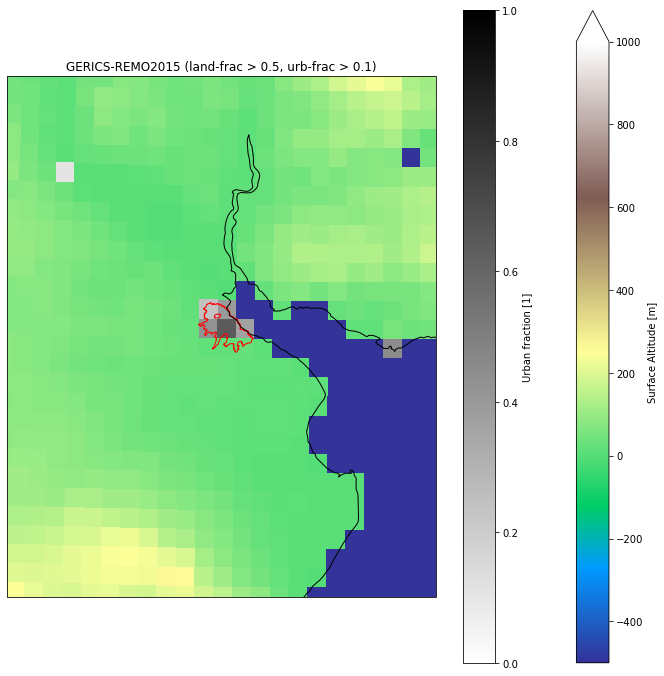

In [8]:
projvar = ords.orog.grid_mapping
proj = ccrs.RotatedPole(
  pole_longitude = ords[projvar].grid_north_pole_longitude,
  pole_latitude = ords[projvar].grid_north_pole_latitude
)
lonlat = ccrs.PlateCarree() 
proj = lonlat                  ####
f = plt.figure(figsize=(12,12))
ax = plt.axes(projection=proj)
ords.orog.where(lfds.sftlf > land_thres*100).fillna(orog_vlim['vmin']).plot(
    ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.terrain, **orog_vlim
)
ufds.sftuf.where(ufds.sftuf > urban_thres).plot(
    ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.gray_r, vmin=0, vmax=1
)
ax.set_extent([clon-size, clon+size, clat-size, clat+size], crs=lonlat)
plt.title(f'{ords.model_id} (land-frac > {land_thres}, urb-frac > {urban_thres})')
ax.coastlines(resolution='10m', linewidth=1, color='k')
t = ucdb_city.plot(ax=ax, transform=lonlat, facecolor="none", edgecolor="red")

## RegCM

In [9]:
ords = xr.open_mfdataset(f'data/RegCM/orography/orog_{domain}_*RegCM*.nc')
lfds = xr.open_mfdataset(f'data/RegCM/land-sea-mask/sftlf_{domain}_*RegCM*.nc')

Fix the raw urban fraction data. In this case, adding all urban fractions corresponding to different building height categories, in order to make it comparable to REMO single urban fraction category.

In [10]:
ufout = f'sftuf_{domain}_ICTP-RegCM4-4_v0_fx.nc'
if os.path.exists(ufout):
  ufds = xr.open_dataset(ufout)
else:
  ufds_orig = xr.open_dataset(f'data/RegCM/urbanfraction/orig/{domain}.nc')
  ufnp = ufds_orig.urb_2d.values.sum(axis = 0)/100.
  ufds = ufds_orig.assign(sftuf = (('iy','jx'), ufnp, dict(
    long_name = 'Urban fraction',
    standard_name = 'urban_area_fraction',
    units = '1',
    cell_measures = 'area: areacella',
    grid_mapping = 'crs'
  )))  
  ufds.to_netcdf(ufout)

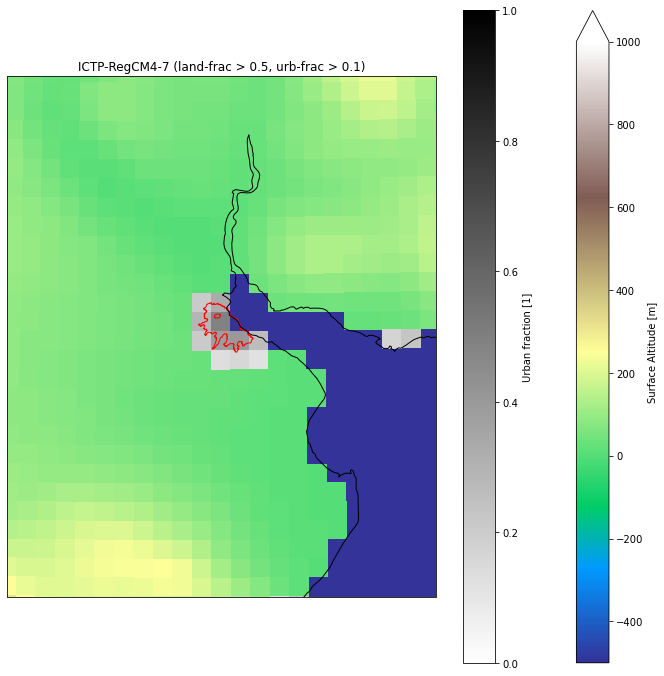

In [11]:
projvar = ords.orog.grid_mapping
#proj = ccrs.LambertConformal(
#  central_longitude = ords[projvar].longitude_of_central_meridian,
#  central_latitude = ords[projvar].latitude_of_projection_origin,
#  standard_parallels = ords[projvar].standard_parallel,
#  false_easting = ords[projvar].false_easting,
#  false_northing = ords[projvar].false_northing,
#ords[projvar].semi_major_axis
#)
lonlat = ccrs.PlateCarree()
proj = lonlat                #####
f = plt.figure(figsize=(12,12))
ax = plt.axes(projection=proj)
ords.orog.where(lfds.sftlf > land_thres*100).fillna(-500).plot(
    ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.terrain, **orog_vlim
)
ufds.sftuf.where(ufds.sftuf > urban_thres).plot(
    ax=ax, x='xlon', y='xlat', transform=lonlat, cmap=plt.cm.gray_r, vmin=0, vmax=1
)
ax.set_extent([clon-size, clon+size, clat-size, clat+size], crs=lonlat)
plt.title(f'{ords.model_id} (land-frac > {land_thres}, urb-frac > {urban_thres})')
ax.coastlines(resolution='10m', linewidth=1, color='k')
t = ucdb_city.plot(ax=ax, transform=lonlat, facecolor="none", edgecolor="red")